In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd

Using TensorFlow backend.


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Random Forest Regression

In [3]:
df1 = pd.read_csv('/Users/harishpuvvada/Desktop/PBDA/IPynbSpark/datafileRandom.csv',header=None)
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2017-11-24T07:00:00.000-05:00,0.027494,0.877247,0.095263,0.127638,8249.12
1,2017-11-24T08:00:00.000-05:00,0.025581,0.868727,0.105001,0.168291,8241.95
2,2017-11-24T09:00:00.000-05:00,0.025951,0.858296,0.115159,0.192677,8202.17
3,2017-11-24T10:00:00.000-05:00,0.027064,0.867925,0.104772,0.179318,8186.82
4,2017-11-24T11:00:00.000-05:00,0.035105,0.856513,0.106731,0.161383,8242.31


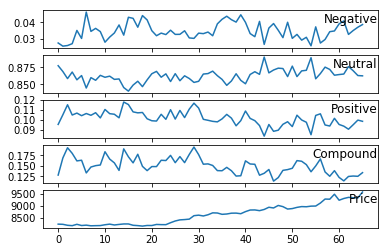

In [4]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [5]:
df1.set_index('DateTime',inplace=True)  #making DateTime as index. Because we are doing Time series Analysis

cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2017-11-24T07:00:00.000-05:00,8249.12,0.027494,0.877247,0.095263,0.127638
2017-11-24T08:00:00.000-05:00,8241.95,0.025581,0.868727,0.105001,0.168291
2017-11-24T09:00:00.000-05:00,8202.17,0.025951,0.858296,0.115159,0.192677
2017-11-24T10:00:00.000-05:00,8186.82,0.027064,0.867925,0.104772,0.179318
2017-11-24T11:00:00.000-05:00,8242.31,0.035105,0.856513,0.106731,0.161383


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling values from 0 to 1
scaled = scaler.fit_transform(df1.values)

n_hours = 3
n_features = 5              
n_obs = n_hours*n_features

reframed = series_to_supervised(scaled, n_hours, 1)  #t-3,t-2,t-1 values of all the columns. you can change n_hours for this
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.057253,0.092647,0.746102,0.343747,0.176512,0.052143,0.000000,0.576052,0.625611,0.678122,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179
4,0.052143,0.000000,0.576052,0.625611,0.678122,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885
5,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581
6,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581,0.027882,1.000000,0.091540,0.663118,0.239854
7,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581,0.027882,1.000000,0.091540,0.663118,0.239854,0.008795,0.432587,0.396058,0.611329,0.413184


In [7]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)  #dropping all the present values except present price
reframed.head()  #Note: here last column is present price which is our target variable

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.057253,0.092647,0.746102,0.343747,0.176512,0.052143,0.000000,0.576052,0.625611,0.678122,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850
4,0.052143,0.000000,0.576052,0.625611,0.678122,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400
5,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205
6,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581,0.027882
7,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581,0.027882,1.000000,0.091540,0.663118,0.239854,0.008795


In [8]:
cols = reframed.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
reframed = reframed[cols]
reframed.head()

,var1(t),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
3,0.012850,0.057253,0.092647,0.746102,0.343747,0.176512,0.052143,0.000000,0.576052,0.625611,0.678122,0.023791,0.017944,0.367851,0.919633,0.979017
4,0.052400,0.052143,0.000000,0.576052,0.625611,0.678122,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179
5,0.017205,0.023791,0.017944,0.367851,0.919633,0.979017,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885
6,0.027882,0.012850,0.071824,0.560053,0.618990,0.814179,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581
7,0.008795,0.052400,0.461125,0.332280,0.675692,0.592885,0.017205,0.226068,0.456605,0.599701,0.612581,0.027882,1.000000,0.091540,0.663118,0.239854


In [9]:
from pyspark.ml.linalg import Vectors
reg_DF =sql.createDataFrame(reframed)
ad_df = reg_DF.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])
ad_df.show(5)

+--------------------+--------------------+
|            features|               label|
+--------------------+--------------------+
|[0.05725343178481...| 0.01285048394224031|
|[0.05214317277949...| 0.05239975482160375|
|[0.02379085712656...| 0.01720525137912876|
|[0.01285048394224...|0.027881915242399025|
|[0.05239975482160...|0.008795062221145677|
+--------------------+--------------------+
only showing top 5 rows



In [10]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [11]:
lr_model = lr.fit(ad_df)

In [12]:
predictions = lr_model.transform(ad_df)

someDF = predictions.select("prediction", "label").show(5)

+--------------------+--------------------+
|          prediction|               label|
+--------------------+--------------------+
| 0.04887234681841157| 0.01285048394224031|
| 0.04292473119310247| 0.05239975482160375|
| 0.07042838831654907| 0.01720525137912876|
|0.057255321725432795|0.027881915242399025|
| 0.00886748796143344|0.008795062221145677|
+--------------------+--------------------+
only showing top 5 rows



In [13]:
predictions = predictions.toPandas().head()

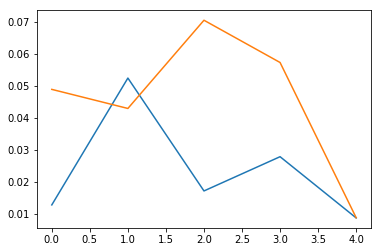

In [14]:
plt.plot(predictions['label'])
plt.plot(predictions['prediction'])
plt.show()

In [ ]:
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

In [ ]:
trainingSummary = lr_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [ ]:
# # invert scaling for forecast
# inv_yhat = np.concatenate((predictions[-1], predictions[:, -2:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, -2:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
plt.plot(predictions[])

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator 
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
evaluator.evaluate(ad_pred, {evaluator.metricName: "r2"})

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.ml.feature import VectorIndexer
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.mllib.regression import LabeledPoint
# from pyspark.mllib.util import MLUtils

# reg_DF =sql.createDataFrame(reframed)
# c = reg_DF.rdd
# c.take(3)

# d = c.map(lambda line: LabeledPoint(line[0],[line[1:]])) # arbitrary mapping, it's just an example
# print (d.take(3))

# MLUtils.saveAsLibSVMFile(d,"/Users/harishpuvvada/Desktop/PBDA/IPynbSpark/libsvm")

In [ ]:
values = reframed.values
n_train_hours = 50
train = values[:n_train_hours, :]   #
test = values[n_train_hours:, :]
train.shape

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [ ]:
plt.show()

In [ ]:
inv_yhat.shape

In [ ]:
c = np.concatenate(inv_y,inv_yhat)

In [ ]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})

In [ ]:
df_sol.to_csv('Predictions_nosent.csv')